## Valuable assets for Wild fires - Introduction to vector data in python 

In this chapter we are going to create a datalayer containing the vital infrastructure and built-up areas of our study area. For this we will use open vectordata, thus points, lines or polygons with attribute information. We will use a the GADM data for a polygon of our study area. For the vital infrastructure we will use Open Street Map data. To generate a datalayer from these dataset that contains valuable assets, a series of processing steps need to be performed. 

## Goals of episode 
In this episode you will learn a series of processing steps that provides an introduction to work with vector geo data in python. The processings step that will be demonstrated in this episode are:

- explore vector data in python using geopandas 
- selecting objects based on attributive information
- assign and modify a projected coordinate system to your data
- assign a buffer to your vector data
- store processed data as a new vector layer
- visualize vectordata in jupyter notebook

## Datasets
As stated above the dataset that we are using are for our study area are: 

1. Database of Global Administrative Areas [GADM](https://gadm.org/). Download [link](https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_GRC_shp.zip) to obtain a boundary of our study area.

2. OpenStreetMap (OSM) data downloaded from [geofabrik](download.geofabrik.de). Download [link](https://download.geofabrik.de/europe/greece-latest-free.shp.zip) to retrieve the vital infrastructure and built-up areas of our study area.

In [1]:
# # Data preparation OSM
# labels = ['roads', 'buildings', 'landuse', 'transport']
# bbox=(25, 34, 29, 38)
# p_roads = './data/osm_all/gis_osm_roads_free_1.shp'
# p_buildings = './data/osm_all/gis_osm_buildings_a_free_1.shp'
# p_landuse = './data/osm_all/gis_osm_landuse_a_free_1.shp'
# p_transport = './data/osm_all/gis_osm_transport_a_free_1.shp'

# for label, path in zip(labels, [p_roads, p_buildings, p_landuse, p_transport]):
#     data_crop = gpd.read_file(path, bbox=(25, 34, 29, 38))
#     data_crop.to_parquet(f'{label}.gpkg')

In [2]:
# # # Data preparation GADM
# greece = gpd.read_file('./data/gadm/gadm41_GRC_3.shp')
# greece.to_file('greece.gpkg')

## Get the administration boundary of study area

For this episode we decided to look at the Greek island Rhodos. The first step that we are going to take is to import the library geopandas into our jupyter notebook. 

In [3]:
import geopandas as gpd

Next, we are going to import teh GADM data for Greece as a geopandas data frame. 

In [4]:
gdf_greece = gpd.read_file('./data/gadm/greece.gpkg')

To explore the dataframe we can call the variable. (or use other pandas dataframe functions like .shape, .head and .tail etc.) Identify which collumn we could use to select the polygon for the island Rhodos.

In [5]:
gdf_greece

,GID_3,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
0,GRC.1.1.1_1,GRC,Greece,GRC.1_1,Aegean,Αιγαίο,GRC.1.1_1,North Aegean,Βόρειο Αιγαίο,Agios Efstratios,Aghios Efstratios,Αγίου Ευστρατίου,Dímos,Municipality,NA,GR.AI.AE,"MULTIPOLYGON (((25.00375 39.56264, 25.00430 39..."
1,GRC.1.1.2_1,GRC,Greece,GRC.1_1,Aegean,Αιγαίο,GRC.1.1_1,North Aegean,Βόρειο Αιγαίο,Chios,NA,Χίου,Dímos,Municipality,NA,GR.AI.XS,"MULTIPOLYGON (((25.90431 38.22025, 25.90431 38..."
2,GRC.1.1.3_1,GRC,Greece,GRC.1_1,Aegean,Αιγαίο,GRC.1.1_1,North Aegean,Βόρειο Αιγαίο,Fournoi Korseon,Fourni Korseon,Φούρνων Κορσεών,Dímos,Municipality,NA,GR.AI.FK,"MULTIPOLYGON (((26.48931 37.51764, 26.48931 37..."
3,GRC.1.1.4_1,GRC,Greece,GRC.1_1,Aegean,Αιγαίο,GRC.1.1_1,North Aegean,Βόρειο Αιγαίο,Ikaria,Icaria,Ικαριάς,Dímos,Municipality,NA,GR.AI.IK,"POLYGON ((26.02431 37.51653, 26.02431 37.51625..."
4,GRC.1.1.5_1,GRC,Greece,GRC.1_1,Aegean,Αιγαίο,GRC.1.1_1,North Aegean,Βόρειο Αιγαίο,Lemnos,Limnos,Λήμνου,Dímos,Municipality,NA,GR.AI.LM,"MULTIPOLYGON (((25.23597 39.79292, 25.23597 39..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,GRC.8.2.21_1,GRC,Greece,GRC.8_1,Thessaly and Central Greece,Θεσσαλία και Στερεά Ελλάδα,GRC.8.2_1,Thessaly,Θεσσαλία,Tempi,Tempes,Τεμπών,Dímos,Municipality,NA,GR.TC.TE,"POLYGON ((22.48664 39.99766, 22.48566 39.99689..."
322,GRC.8.2.22_1,GRC,Greece,GRC.8_1,Thessaly and Central Greece,Θεσσαλία και Στερεά Ελλάδα,GRC.8.2_1,Thessaly,Θεσσαλία,Trikala,NA,Τρικκαίων,Dímos,Municipality,NA,GR.TC.TR,"POLYGON ((21.93094 39.76662, 21.93168 39.76571..."
323,GRC.8.2.23_1,GRC,Greece,GRC.8_1,Thessaly and Central Greece,Θεσσαλία και Στερεά Ελλάδα,GRC.8.2_1,Thessaly,Θεσσαλία,Tyrnavos,NA,Τυρνάβου,Dímos,Municipality,NA,GR.TC.TY,"POLYGON ((22.13472 39.65499, 22.13510 39.65574..."
324,GRC.8.2.24_1,GRC,Greece,GRC.8_1,Thessaly and Central Greece,Θεσσαλία και Στερεά Ελλάδα,GRC.8.2_1,Thessaly,Θεσσαλία,Volos,NA,Βόλου,Dímos,Municipality,NA,GR.TC.VO,"POLYGON ((22.81903 39.27344, 22.81884 39.27332..."


To visualize the geo data frame we can using the .plot function.

<Axes: >

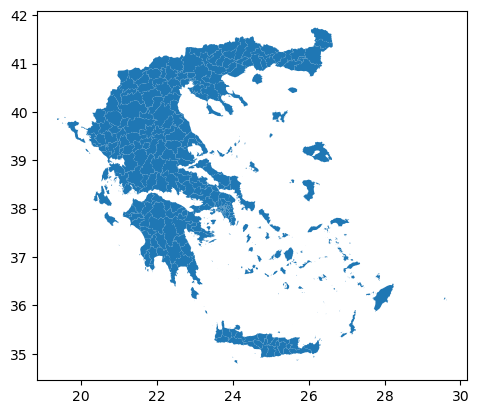

In [6]:
gdf_greece.plot()

Now, the next step is to select the object with as attribute Rhodos. Above you should have identified the collumn "NAME_3" to be a suitable candidate to isolate the island Rhodos from our geo data frame. Let us create a new variable that only contains a polygon for the island Rhodos.

In [7]:
gdf_rhodes = gdf_greece.loc[gdf_greece['NAME_3']=='Rhodos']


Let us see how it looks like by calling our newly created variable.

In [8]:
gdf_rhodes

,GID_3,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
34,GRC.1.2.26_1,GRC,Greece,GRC.1_1,Aegean,Αιγαίο,GRC.1.2_1,South Aegean,Νότιο Αιγαίο,Rhodos,Rhodes,Ρόδου,Dímos,Municipality,NA,GR.AI.RH,"MULTIPOLYGON (((27.75792 35.88792, 27.75903 35..."


Now let us plot it again. 

<Axes: >

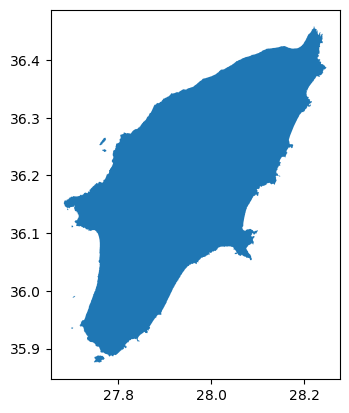

In [9]:
gdf_rhodes.plot()

To save the newly created geo dataframe as a geo package file on your local machine we can use the .to_file function. 

In [10]:
# Save the rhodes_boundary to gpkg
gdf_rhodes.to_file('rhodes.gpkg')

## Get valuable assests from OpenStreetMap

### Get road data from OpenStreetMap

Now that we have the boundary of our study area, we will make use this to select the main roads in our study area. We will make the following processing steps:
1. Select roads of study area
2. Select key infrastruture roads: 'primary', 'secondary', 'tertiary'
3. Create a 100m buffer around the rounds. This buffer will be regarded as the infrastructure region. (note that this buffer is arbitrary and can be changed afterwards if you want!)

For you convinience we created a subset of the data from Greece, however we have not made a subselection of our study area yet! Now read the geopackage roads.gpkg as a geo dataframe

In [11]:
gdf_roads = gpd.read_file('./data/osm/roads.gpkg')

Explore the geodataframe using the same commands as above. 

<Axes: >

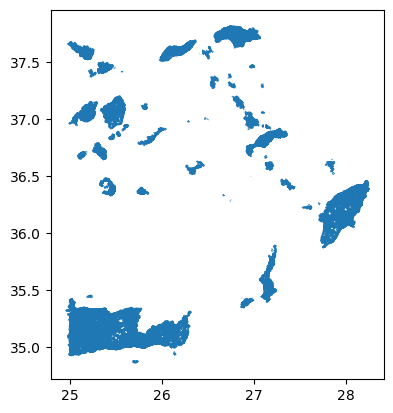

In [12]:
gdf_roads.plot()

In order to only get the roads of our study area, we will use the geo data frame of the study area created above and add it as a mask on our roads geo data frame.

In [13]:
# Read data with a mask of Rhodes
gdf_roads = gpd.read_file('./data/osm/roads.gpkg', mask=gdf_rhodes)

Now explore the geodataframe again by using the same commands as above. 

<Axes: >

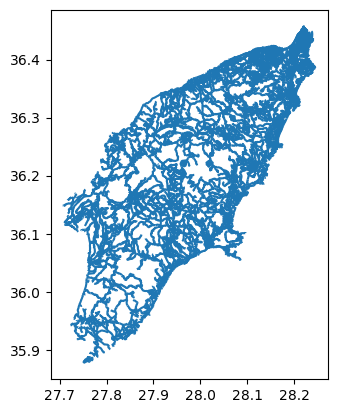

In [14]:
gdf_roads.plot()

In [15]:
gdf_roads

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,81194256,5121,unclassified,NaN,NaN,B,0,0,F,F,"LINESTRING (27.73144 36.12638, 27.73142 36.126..."
1,172757595,5153,footway,NaN,NaN,B,0,0,F,F,"LINESTRING (27.71921 36.12761, 27.71936 36.127..."
2,239479606,5147,track_grade5,NaN,NaN,B,0,0,F,F,"LINESTRING (27.75890 36.12877, 27.75839 36.128..."
3,239369975,5141,service,NaN,NaN,B,0,0,F,F,"LINESTRING (27.73525 36.12871, 27.73541 36.128..."
4,239369955,5141,service,NaN,NaN,B,0,0,F,F,"LINESTRING (27.73601 36.12897, 27.73591 36.129..."
...,...,...,...,...,...,...,...,...,...,...,...
18879,875722036,5114,secondary,Καλλιθέας,NaN,F,40,0,F,F,"LINESTRING (28.22949 36.41861, 28.22959 36.41855)"
18880,875722037,5114,secondary,Ρόδος - Καλλιθέα,NaN,F,50,0,F,F,"LINESTRING (28.22949 36.41861, 28.22930 36.418..."
18881,920166404,5141,service,NaN,NaN,B,0,0,F,F,"LINESTRING (28.23022 36.41723, 28.23025 36.417..."
18882,920166405,5141,service,NaN,NaN,B,0,0,F,F,"LINESTRING (28.23064 36.41759, 28.23035 36.41759)"


The masked geo data frame of our roads contains all kind of hiking paths and footpaths as well. Since we are interested in vital infrastructure, classified as primary, secondary and tertiary roads, we are going to make a subselection of our data frame by looking at the attributes. 

However, let us first explore which values our roads geo data frame has.

In [16]:
gdf_roads['fclass'].unique()

array(['unclassified', 'footway', 'track_grade5', 'service',
       'residential', 'path', 'track', 'secondary', 'steps', 'tertiary',
       'track_grade2', 'track_grade3', 'track_grade4', 'pedestrian',
       'tertiary_link', 'track_grade1', 'secondary_link', 'primary',
       'living_street', 'primary_link', 'cycleway'], dtype=object)

Now let us focus at primary roads. 

<Axes: >

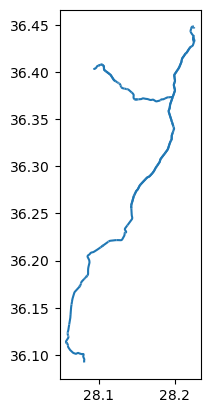

In [17]:
# visulize the primary roads
primary_roads = gdf_roads.loc[gdf_roads['fclass']=='primary']
primary_roads.plot()

Now we are going to create a list of attributes we consider vital infrastructure. 

In [18]:
# Extract infrastratcure roads
infra_labels = ['primary', 'secondary', 'tertiary']

infra_roads = gdf_roads.loc[gdf_roads['fclass'].isin(infra_labels)]

Let us create a plot again. 

<Axes: >

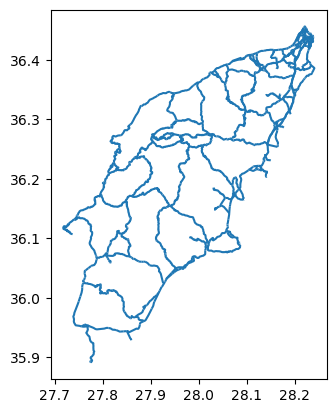

In [19]:
infra_roads.plot()

## Make 100m buffer around the infrastructure roads

In order to create a 100m buffer, we need first transform the data into a CRS with length unit. The current data has a geographica coordinate system, but is not yet projected. It is therefore not possible to put a buffer around, since it measures in degrees and not meters. In order to add a buffer in meters around it, it thus needs to be projected. In our case we decided to project the data as [GGRS87](https://epsg.io/2100), with EPSG code 2100.

To project the geo dataframe we use geopandas´ .to_crs function. 

In [20]:
# Covert to a crs with meters unit
infra_roads_meters = infra_roads.to_crs(2100)

Now that is it projected, we can creat a buffer around it calling geopandas´ buffer function. 

In [21]:
# Create buffer, note that the gdf changed to a GeoSeries
infra_roads_meters_buffer = infra_roads_meters.buffer(100)
infra_roads_meters_buffer

45       POLYGON ((835416.042 4003863.922, 835427.364 4...
58       POLYGON ((834402.929 4003012.515, 834401.865 4...
99       POLYGON ((838546.789 3984903.614, 838553.301 3...
100      POLYGON ((839682.491 3984773.465, 839679.219 3...
108      POLYGON ((839650.528 3984897.525, 839646.746 3...
                               ...                        
18876    POLYGON ((879037.642 4038438.581, 879042.908 4...
18877    POLYGON ((879007.931 4038379.355, 879012.724 4...
18878    POLYGON ((879045.833 4038454.892, 879050.667 4...
18879    POLYGON ((879188.948 4038486.610, 879196.752 4...
18880    POLYGON ((879190.669 4038322.167, 879181.177 4...
Length: 1369, dtype: geometry

Now that we have a buffer, we can convert it back to the geographic coordinate system. 

In [22]:
infra_roads_buffer  = infra_roads_meters_buffer.to_crs(4326)


Now let us explore the buffered road geodataframe. 

In [23]:
infra_roads_buffer

45       POLYGON ((27.72826 36.12409, 27.72839 36.12426...
58       POLYGON ((27.71666 36.11678, 27.71665 36.11678...
99       POLYGON ((27.75485 35.95242, 27.75493 35.95248...
100      POLYGON ((27.76737 35.95086, 27.76733 35.95086...
108      POLYGON ((27.76706 35.95199, 27.76702 35.95201...
                               ...                        
18876    POLYGON ((28.22855 36.41890, 28.22861 36.41899...
18877    POLYGON ((28.22819 36.41838, 28.22825 36.41845...
18878    POLYGON ((28.22865 36.41904, 28.22871 36.41912...
18879    POLYGON ((28.23026 36.41927, 28.23034 36.41921...
18880    POLYGON ((28.23020 36.41779, 28.23007 36.41745...
Length: 1369, dtype: geometry

<Axes: >

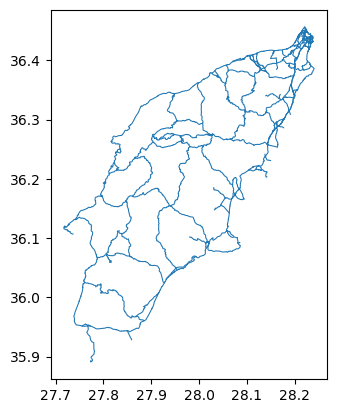

In [24]:
infra_roads_buffer.plot()

Reprojecting and buffering our data is something that we are going to do multiple times during this episode. To avoid have to call the same functions multiple times it would make sense to create a function. Let us create a function in which we can add the buffer as a variable. 

In [25]:
def buffer_crs(gdf, size, meter_crs=2100, target_crs=4326):
    return gdf.to_crs(meter_crs).buffer(size).to_crs(target_crs)

To call this function we do.

In [26]:
infra_roads_buffer = buffer_crs(infra_roads, 100)

Now let us explore our data agian. 

In [27]:
infra_roads_buffer

45       POLYGON ((27.72826 36.12409, 27.72839 36.12426...
58       POLYGON ((27.71666 36.11678, 27.71665 36.11678...
99       POLYGON ((27.75485 35.95242, 27.75493 35.95248...
100      POLYGON ((27.76737 35.95086, 27.76733 35.95086...
108      POLYGON ((27.76706 35.95199, 27.76702 35.95201...
                               ...                        
18876    POLYGON ((28.22855 36.41890, 28.22861 36.41899...
18877    POLYGON ((28.22819 36.41838, 28.22825 36.41845...
18878    POLYGON ((28.22865 36.41904, 28.22871 36.41912...
18879    POLYGON ((28.23026 36.41927, 28.23034 36.41921...
18880    POLYGON ((28.23020 36.41779, 28.23007 36.41745...
Length: 1369, dtype: geometry

## Get built-up regions

Now that we have our roads, we are going to create a layer for the built-up areas. We will assume built-up regions are the union of three component derived from OpenStreetMaps:

- Buildings, since OSM is not complete for our study area we also need to add additional layers from the Land Use datalayer
- Land use that has commercial/industial/residential as type. 
- Transportation areas, containing areas of airports and important transport related regions.

In the next steps we will create buffers of 10 meters around selected polygons and union them into one layer which we consider built-up areas. 

### Select three land use types from the land use data

First we make a subselection form the land use types. We import another geopackage as geo dataframe and directly mask it with for our study area. 

In [28]:
gdf_landuse = gpd.read_file('./data/osm/landuse.gpkg', mask=gdf_rhodes)

Now let us explore our data. 

In [29]:
gdf_landuse

,osm_id,code,fclass,name,geometry
0,283545932,7229,farmland,NaN,"POLYGON ((27.73565 35.95070, 27.73584 35.95094..."
1,353822382,7217,scrub,NaN,"POLYGON ((27.74374 35.94771, 27.74396 35.94807..."
2,3216678,7210,nature_reserve,Πρασονήσι,"POLYGON ((27.74959 35.87780, 27.74985 35.87809..."
3,283545953,7229,farmland,NaN,"POLYGON ((27.75138 35.95258, 27.75274 35.95223..."
4,1196920676,7201,forest,NaN,"POLYGON ((27.75293 35.88491, 27.75330 35.88439..."
...,...,...,...,...,...
6102,166093057,7217,scrub,NaN,"POLYGON ((28.22847 36.42133, 28.22871 36.42164..."
6103,920075982,7217,scrub,NaN,"POLYGON ((28.22852 36.42273, 28.22856 36.42289..."
6104,274255807,7203,residential,NaN,"POLYGON ((28.22865 36.41992, 28.22920 36.41993..."
6105,361451567,7217,scrub,NaN,"POLYGON ((28.22920 36.41920, 28.22922 36.41940..."


Let us look at the various attributes. Which ones fo you think are suitable for our purposes?

In [30]:
# Find the unique land use 
gdf_landuse['fclass'].unique()

array(['farmland', 'scrub', 'nature_reserve', 'forest', 'industrial',
       'farmyard', 'orchard', 'grass', 'residential', 'commercial',
       'retail', 'cemetery', 'heath', 'meadow', 'recreation_ground',
       'quarry', 'military', 'park', 'vineyard'], dtype=object)

### select built up areas from landuse.gpkg 

Create a list of attributes and plot your result. 

<Axes: >

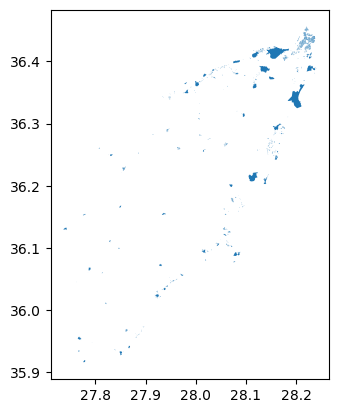

In [31]:
# SOLUTION
# Define built-up labels
builtup_labels = ['commercial', 'industrial', 'residential' ]

# Select built up area
builtup_landuse = gdf_landuse.loc[gdf_landuse['fclass'].isin(builtup_labels)]

builtup_landuse.plot()

In [32]:
builtup_landuse

,osm_id,code,fclass,name,geometry
11,238647753,7204,industrial,NaN,"POLYGON ((27.76578 35.93404, 27.76633 35.93451..."
78,376514386,7204,industrial,NaN,"POLYGON ((27.83789 35.93674, 27.83827 35.93719..."
106,978073993,7203,residential,NaN,"POLYGON ((27.84768 35.93296, 27.84813 35.93316..."
116,353804288,7203,residential,NaN,"POLYGON ((27.85547 35.93281, 27.85607 35.93302..."
134,353804304,7209,commercial,Atrium Prestige Thalasso Spa & Villas,"POLYGON ((27.86529 35.94081, 27.86536 35.94092..."
...,...,...,...,...,...
6097,274255813,7203,residential,NaN,"POLYGON ((28.22707 36.42278, 28.22770 36.42360..."
6098,274255812,7203,residential,NaN,"POLYGON ((28.22766 36.42223, 28.22815 36.42291..."
6100,274255782,7203,residential,NaN,"POLYGON ((28.22817 36.42005, 28.22817 36.42051..."
6101,274255831,7203,residential,NaN,"POLYGON ((28.22830 36.42106, 28.22868 36.42106..."


### Merge in buildings data 

Not all buildings in our study area are within the land-use type boundaries determined above. Some of them are more remote. We therefore need to merge the buildings into our newly created layer and add a buffer around them as well.   

Let us first load the buildings geopackage as a geo dataframe and directly put a mask on it. 

In [33]:
builtup_buildings = gpd.read_file('./data/osm/buildings.gpkg', mask=gdf_rhodes)

Explore the geo data frame.

<Axes: >

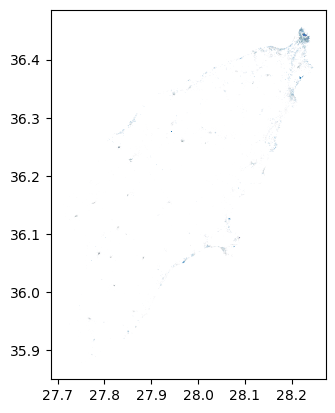

In [34]:
builtup_buildings.plot()

**Exercise: Make 10m buffer for landuse and buildings**

Now we have two components of built-up area: `builtup_landuse` and `builtup_buildings`. Can you grow a 10 meter buffer for both datasets? (Hint: use the function we have created for infrastructures.)

<Axes: >

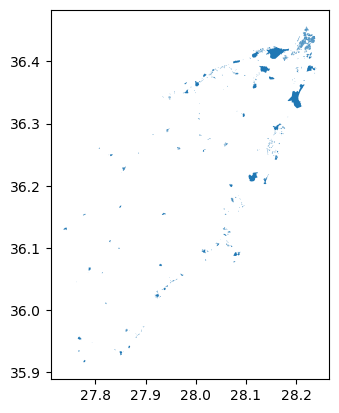

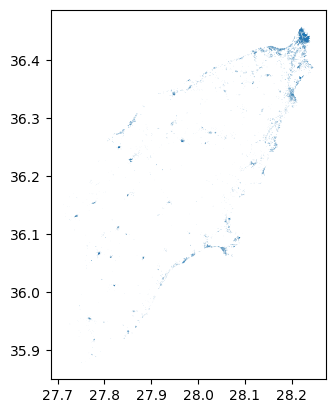

In [35]:
# Exercise: Make 50m buffer for the "builtup_buildings" and "builtup_buildings" using buffer_crs function
builtup_landuse_buffer = buffer_crs(builtup_landuse, 10)
builtup_buildings_buffer = buffer_crs(builtup_buildings, 10)

builtup_landuse_buffer.plot()
builtup_buildings_buffer.plot()

To merge two geo dataframe we can use the concat function form pandas. However, in order to call this one, you will need to first import the pandas library.  

In [36]:
import pandas as pd

Now that pandas is loaded we can merge the two geo dataframes. 

In [37]:
pd.concat([builtup_landuse_buffer, builtup_buildings_buffer])

11       POLYGON ((27.76568 35.93400, 27.76568 35.93400...
78       POLYGON ((27.83782 35.93667, 27.83781 35.93667...
106      POLYGON ((27.84760 35.93290, 27.84759 35.93291...
116      POLYGON ((27.85537 35.93277, 27.85537 35.93277...
134      POLYGON ((27.86525 35.94073, 27.86524 35.94073...
                               ...                        
22020    POLYGON ((28.22548 36.43252, 28.22547 36.43252...
22021    POLYGON ((28.22567 36.43347, 28.22565 36.43347...
22022    POLYGON ((28.22579 36.43229, 28.22578 36.43230...
22023    POLYGON ((28.22584 36.43243, 28.22583 36.43243...
22024    POLYGON ((28.22592 36.43231, 28.22592 36.43231...
Length: 23361, dtype: geometry

Now let us redo the whole thing, but with a for loop which calls our buffer function and merges the two dataset into a new one showing you the real strength of working with python! 

In [38]:
# Make a for loop to append buffers from different sources
builtup_buffer = None
list_gdf = [builtup_landuse, builtup_buildings]
for gdf in list_gdf:
    if builtup_buffer is None:
        builtup_buffer = buffer_crs(gdf, 10)
    else:
        gdf_buffer = buffer_crs(gdf, 10)
        builtup_buffer = pd.concat([builtup_buffer, gdf_buffer])

### Merge in transport data

**Exercise: Merge three buffers**

There is still one component missing for the builtup area, which is the "transportation" dataset. It is stored in `./data/osm/transport.gpkg`. 

In this exercise, please:
1. Load the transportation areas on Rhodes Islands.
2. Grow a **10m** buffer around the transportation datasets
3. Merge the three buffers (10m buffers of landuse, buildings and tranportation) into one dataset.

(Hint: re-use the code!)

In [39]:
# Exercise: include transport data into builtup area
builtup_tranport = gpd.read_file('./data/osm/transport.gpkg', mask=gdf_rhodes)

builtup_buffer = None
list_gdf = [builtup_landuse, builtup_buildings, builtup_tranport]
for gdf in list_gdf:
    if builtup_buffer is None:
        builtup_buffer = buffer_crs(gdf, 10)
    else:
        gdf_buffer = buffer_crs(gdf, 10)
        builtup_buffer = pd.concat([builtup_buffer, gdf_buffer])

In [40]:
builtup_buffer

11     POLYGON ((27.76568 35.93400, 27.76568 35.93400...
78     POLYGON ((27.83782 35.93667, 27.83781 35.93667...
106    POLYGON ((27.84760 35.93290, 27.84759 35.93291...
116    POLYGON ((27.85537 35.93277, 27.85537 35.93277...
134    POLYGON ((27.86525 35.94073, 27.86524 35.94073...
                             ...                        
9      POLYGON ((28.08787 36.40361, 28.08787 36.40362...
10     POLYGON ((28.08862 36.40433, 28.08861 36.40433...
11     POLYGON ((28.19022 36.41792, 28.19022 36.41793...
12     POLYGON ((28.21801 36.36652, 28.21800 36.36653...
13     POLYGON ((28.06574 36.10931, 28.06573 36.10931...
Length: 23375, dtype: geometry

## Simplify the built-up polygons

The dataset we created has a lot of overlapping geometries, making it unecessary complex for later calculations. We therefore union the newly created geo dataframe by using the `.unary_union` function to union all ploygons into one and then put them into a GeoSeries.

In [41]:
gs_infrastrcture = gpd.GeoSeries(infra_roads_buffer.unary_union, crs=builtup_buffer.crs)
gs_infrastrcture

0    POLYGON ((27.77240 35.89279, 27.77240 35.89280...
dtype: geometry

In [42]:
gs_builtup = gpd.GeoSeries(builtup_buffer.unary_union, crs=builtup_buffer.crs)
gs_builtup

0    MULTIPOLYGON (((27.75075 35.87857, 27.75075 35...
dtype: geometry

In [43]:
gs_assets = pd.concat([gs_infrastrcture, gs_builtup]).reset_index(drop=True)

In [44]:
gs_assets

0    POLYGON ((27.77240 35.89279, 27.77240 35.89280...
1    MULTIPOLYGON (((27.75075 35.87857, 27.75075 35...
dtype: geometry

In [45]:
data = {'code':[1, 2], 
        'type': ['infrastructure', 'built-up' ],
        'geometry': gs_assets}
gdf_assets = gpd.GeoDataFrame(data)

In [46]:
gdf_assets

,code,type,geometry
0,1,infrastructure,"POLYGON ((27.77240 35.89279, 27.77240 35.89280..."
1,2,built-up,"MULTIPOLYGON (((27.75075 35.87857, 27.75075 35..."


To explore our geo dataframe we can also create a thematic map assigning different colors and a legend to our geo data frame. 

<Axes: >

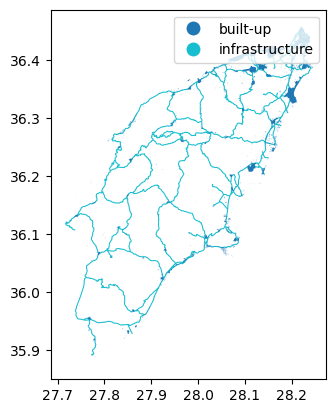

In [47]:
# Visualize by types
gdf_assets.plot(column='type', legend=True)

Now that we have created a new geo data frame with valuable assets, we can store it locally as a geopackage using geopanda´s .to_file function.   

In [48]:
gdf_assets.to_file('assets.gpkg')